# XGBoost

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import pandas_ta as ta
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
import matplotlib.ticker as ticker # 用于格式化日期

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
warnings.filterwarnings('ignore')

## Data Processing

In [3]:
# 1. 定义您的CSV文件所在的文件夹路径
folder_path = '../data/processed/single_stock_data_1/' 

all_files = glob.glob(os.path.join(folder_path, "*.csv"))

# 3. 创建一个空列表，用于存放每个单独的 DataFrame
df_list = []

# 4. 循环遍历所有找到的文件路径
for file_path in all_files:
    # 5. 从文件路径中提取 stock_id
    # os.path.basename 会获取文件名 (例如 "stock_123.csv")
    filename = os.path.basename(file_path)
    
    # 使用 .split('.') 来分离文件名和扩展名
    # "stock_123.csv" -> ["stock_123", "csv"]
    # 我们取第 [0] 个元素，即 "stock_123"
    stock_id = filename.split('.')[0]
    
    # 6. 读取当前的 CSV 文件
    try:
        df = pd.read_csv(file_path)
        
        # 7. 新增一列 "stock_id"，并赋值
        df['stock_id'] = stock_id
        
        # 8. 将处理好的 DataFrame 添加到列表中
        df_list.append(df)
        
    except Exception as e:
        print(f"读取文件 {file_path} 时出错: {e}")

# 9. 检查列表是否为空
if df_list:
    # 使用 pd.concat 将列表中的所有 DataFrame 纵向合并 (axis=0)
    # ignore_index=True 会重新生成一个从 0 开始的连续索引
    panel_data = pd.concat(df_list, axis=0, ignore_index=True)
    
    print("数据合并成功！")
    print("----- 合并后的数据 (前5行) -----")
    print(panel_data.head())
    print("\n----- 合并后的数据 (后5行) -----")
    print(panel_data.tail())
    
    # (可选) 保存合并后的数据到一个新的 CSV 文件
    # panel_data.to_csv("merged_panel_data.csv", index=False)
    
else:
    print("在指定路径下没有找到任何 CSV 文件。")

数据合并成功！
----- 合并后的数据 (前5行) -----
       Date     high      low     open    close      pb  pct_chg_b  pe_ttm  \
0  2020/9/1  36.1570  35.6189  35.9993  35.8787  4.3348    -0.8462  4.3348   
1  2020/9/2  36.5096  35.8045  35.9900  36.0364  4.3538     0.4396  4.3538   
2  2020/9/3  35.7209  34.7467  35.7209  34.9416  4.2215    -3.0381  4.2215   
3  2020/9/4  34.7931  34.2550  34.3385  34.7746  4.2014    -0.4780  4.2014   
4  2020/9/7  34.9230  33.8653  34.7746  33.9581  4.1027    -2.3479  4.1027   

       turn    volume   amount     vwap  pct_chg_f stock_id  
0  230.2915  48858879  18.8582  35.8113  -0.846200   000063  
1  231.3039  50410520  19.6242  36.1188   0.439537   000063  
2  224.2766  94640768  35.8995  35.1943  -3.038039   000063  
3  223.2047  41976286  15.6274  34.5417  -0.477940   000063  
4  217.9640  53251749  19.7132  34.3468  -2.347978   000063  

----- 合并后的数据 (后5行) -----
            Date    high     low    open   close      pb  pct_chg_b  pe_ttm  \
60865  2025/9/22  129

In [4]:
df = panel_data.copy()

df = df.drop('pct_chg_b',axis=1)

df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by=['stock_id', 'Date'])

df = df.set_index(['Date','stock_id'])

df

,,high,low,open,close,pb,pe_ttm,turn,volume,amount,vwap,pct_chg_f
Date,stock_id,,,,,,,,,,,
2020-09-01,000063,36.1570,35.6189,35.9993,35.8787,4.3348,4.3348,230.2915,48858879,18.8582,35.8113,-0.846200
2020-09-02,000063,36.5096,35.8045,35.9900,36.0364,4.3538,4.3538,231.3039,50410520,19.6242,36.1188,0.439537
2020-09-03,000063,35.7209,34.7467,35.7209,34.9416,4.2215,4.2215,224.2766,94640768,35.8995,35.1943,-3.038039
2020-09-04,000063,34.7931,34.2550,34.3385,34.7746,4.2014,4.2014,223.2047,41976286,15.6274,34.5417,-0.477940
2020-09-07,000063,34.9230,33.8653,34.7746,33.9581,4.1027,4.1027,217.9640,53251749,19.7132,34.3468,-2.347978
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,688981,129.8300,119.0500,120.5400,128.9200,6.8278,6.8278,316.2637,158828147,198.5861,125.0321,6.246910
2025-09-23,688981,129.3300,122.6300,127.6400,128.5100,6.8061,6.8061,315.2579,144127353,181.2012,125.7230,-0.318027
2025-09-24,688981,137.9800,126.2300,126.8800,134.9800,7.1488,7.1488,331.1300,146094753,194.9752,133.4581,5.034628


In [5]:
# pick the specified stock
INDEX = 20

unique_ids = df.index.get_level_values('stock_id').unique()

unique_id_list = unique_ids.tolist()

stock_df = df.xs(unique_id_list[INDEX - 1], level='stock_id')

stock_df

,high,low,open,close,pb,pe_ttm,turn,volume,amount,vwap,pct_chg_f
Date,,,,,,,,,,,
2020-09-01,2.8818,2.8676,2.8676,2.8747,0.7047,0.7047,-835.4743,87702448,3.5311,2.8720,0.000000
2020-09-02,2.8747,2.8462,2.8747,2.8533,0.6995,0.6995,-829.2549,99417007,3.9851,2.8594,-0.744426
2020-09-03,2.8676,2.8390,2.8533,2.8462,0.6977,0.6977,-827.1817,108358605,4.3302,2.8506,-0.248835
2020-09-04,2.8462,2.8248,2.8390,2.8390,0.6960,0.6960,-825.1086,118317300,4.6992,2.8331,-0.252969
2020-09-07,2.8390,2.8176,2.8319,2.8248,0.6925,0.6925,-820.9623,110020047,4.3669,2.8313,-0.500176
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,5.3700,5.3100,5.3600,5.3200,0.7893,0.7893,19.1352,111487658,5.9375,5.3257,-0.746269
2025-09-23,5.3800,5.2700,5.3200,5.3600,0.7952,0.7952,19.2791,142495821,7.6152,5.3441,0.751880
2025-09-24,5.4100,5.3300,5.3600,5.3600,0.7952,0.7952,19.2791,113385423,6.0835,5.3653,0.000000


## Feature Engineering

1. 系统计算常见技术指标（基础技术因子）：
在清洗后的日线数据上，批量计算了各种 单一技术指标，包括：

1）趋势 & 动量类：
* MACD
* 多周期均线 MA_5 / 10 / 20 / 50
* RSI_14, RSI_21
* MOM、ROC 等价格动量

2）波动率类：
* ATR_14
* 20 日收益波动率（rolling std）

3）形态/区间类：
* 布林带（BBANDS）
* 价格在当日高低区间中的位置 price_position

4）成交量 & 量价指标：
* OBV（能量潮）
* AD 指标
* 各种收益率变化 price_change_1d / 5d / 10d


2. 在基础指标之上做“高级特征工程”
构造了很多 组合型 / 交互型 / 结构型特征，包括：

1）交互与组合特征：
* RSI × 均线 / 价格
* MACD × 成交量相对均量
* 价格相对 MA × 动量
* trend_strength（多周期均线差的组合）
* momentum_score（RSI × 动量）
* volatility_score（ATR × 波动率）

2）微观结构 & 流动性特征：
* 用 (high−low)/close 近似买卖价差
* OBV / 价格 近似量价趋势
* 成交量 / 均量 作为流动性强弱

3）时间序列动态特征：
* 价格加速度（收益率的一阶差分）
* 成交量加速度

4）相对强弱 & 波动率结构：
* 价格相对 50 日均线（强弱）
* 成交量相对 50 日均量
* 波动率相对长期均值
* 价格变化 × 波动率

5）趋势结构与异常标记
* trend_consistency：MA5>MA10>MA20>MA50 的层层比较，统计趋势一致程度（0–3）
* price_outlier / volume_outlier：标记是否是“异常波动日”或“放量日”

obtain feature matrix

In [16]:
df = stock_df

price_cols = ['open', 'high', 'low', 'close', 'volume'] 
    
# data process
for col in price_cols:
    if col in df.columns:
        # errors='coerce' 会将无效的字符串（如 "N/A"）转为 NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

# 计算更多技术指标
df['RSI_14'] = df.ta.rsi(close='close', length=14)
df['RSI_21'] = df.ta.rsi(close='close', length=21)
df['MA_5'] = df.ta.sma(close='close', length=5)
df['MA_10'] = df.ta.sma(close='close', length=10)
df['MA_20'] = df.ta.sma(close='close', length=20)
df['MA_50'] = df.ta.sma(close='close', length=50)

# 布林带
df.ta.bbands(close='close', length=20, std=2, append=True)

# 威廉指标
df['WILLR_14'] = df.ta.willr(high='high', low='low', close='close', length=14)

# 随机指标
df.ta.stoch(high='high', low='low', close='close', k=14, d=3, append=True)

# 平均真实波幅
df['ATR_14'] = df.ta.atr(high='high', low='low', close='close', length=14)

# 价格动量指标
df['MOM_10'] = df.ta.mom(close='close', length=10)
df['ROC_10'] = df.ta.roc(close='close', length=10)

# 成交量指标
df['OBV'] = df.ta.obv(close='close', volume='volume')
df['AD'] = df.ta.ad(high='high', low='low', close='close', volume='volume')

# 价格位置指标
df['price_position'] = (df['close'] - df['low']) / (df['high'] - df['low'])

# 波动率指标
df['volatility_20'] = df['close'].rolling(20).std()

# 价格变化率
df['price_change_1d'] = df['close'].pct_change(1)
df['price_change_5d'] = df['close'].pct_change(5)
df['price_change_10d'] = df['close'].pct_change(10)

# === 高级特征工程 ===
# 1. 交互特征
df['RSI_MA_interaction'] = df['RSI_14'] * df['MA_20'] / df['close']
df['MACD_volume_interaction'] = df['MACD_12_26_9'] * df['volume'] / df['volume'].rolling(20).mean()
df['price_momentum'] = df['close'] / df['MA_20'] * df['MOM_10']

# 2. 技术指标组合
df['trend_strength'] = (df['MA_5'] - df['MA_20']) / df['MA_20'] + (df['MA_10'] - df['MA_50']) / df['MA_50']
df['momentum_score'] = df['RSI_14'] * df['MOM_10'] / 100
df['volatility_score'] = df['ATR_14'] / df['close'] * df['volatility_20']

# 3. 市场微观结构特征
df['bid_ask_spread_proxy'] = (df['high'] - df['low']) / df['close']  # 买卖价差代理
df['volume_price_trend'] = df['OBV'] / df['close']  # 成交量价格趋势
df['liquidity_score'] = df['volume'] / df['volume'].rolling(20).mean()

# 4. 时间序列特征
df['price_acceleration'] = df['price_change_1d'].diff()  # 价格加速度
df['volume_acceleration'] = df['volume'].pct_change().diff()  # 成交量加速度

# 5. 相对强度特征
df['relative_strength'] = df['close'] / df['close'].rolling(50).mean()
df['relative_volume'] = df['volume'] / df['volume'].rolling(50).mean()

# 6. 波动率特征
df['volatility_ratio'] = df['volatility_20'] / df['volatility_20'].rolling(50).mean()
df['price_volatility_interaction'] = df['price_change_1d'] * df['volatility_20']

# 7. 趋势一致性特征
df['trend_consistency'] = (
    (df['MA_5'] > df['MA_10']).astype(int) + 
    (df['MA_10'] > df['MA_20']).astype(int) + 
    (df['MA_20'] > df['MA_50']).astype(int)
)

# 8. 异常检测特征
df['price_outlier'] = np.abs(df['price_change_1d']) > df['price_change_1d'].rolling(20).std() * 2
df['volume_outlier'] = df['volume'] > df['volume'].rolling(20).mean() * 2

df

,high,low,open,close,pb,pe_ttm,turn,volume,amount,vwap,...,liquidity_score,price_acceleration,volume_acceleration,relative_strength,relative_volume,volatility_ratio,price_volatility_interaction,trend_consistency,price_outlier,volume_outlier
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2.8818,2.8676,2.8676,2.8747,0.7047,0.7047,-835.4743,87702448,3.5311,2.8720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,False
2020-09-02,2.8747,2.8462,2.8747,2.8533,0.6995,0.6995,-829.2549,99417007,3.9851,2.8594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,False
2020-09-03,2.8676,2.8390,2.8533,2.8462,0.6977,0.6977,-827.1817,108358605,4.3302,2.8506,...,NaN,0.004956,-0.043631,NaN,NaN,NaN,NaN,0,False,False
2020-09-04,2.8462,2.8248,2.8390,2.8390,0.6960,0.6960,-825.1086,118317300,4.6992,2.8331,...,NaN,-0.000041,0.001965,NaN,NaN,NaN,NaN,0,False,False
2020-09-07,2.8390,2.8176,2.8319,2.8248,0.6925,0.6925,-820.9623,110020047,4.3669,2.8313,...,NaN,-0.002472,-0.162032,NaN,NaN,NaN,NaN,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,5.3700,5.3100,5.3600,5.3200,0.7893,0.7893,19.1352,111487658,5.9375,5.3257,...,0.644855,-0.000055,0.048885,0.941234,0.683732,1.157023,-0.000847,0,False,False
2025-09-23,5.3800,5.2700,5.3200,5.3600,0.7952,0.7952,19.2791,142495821,7.6152,5.3441,...,0.826816,0.014981,0.425152,0.949346,0.870386,1.158866,0.000866,0,False,False
2025-09-24,5.4100,5.3300,5.3600,5.3600,0.7952,0.7952,19.2791,113385423,6.0835,5.3653,...,0.666493,-0.007519,-0.482420,0.950382,0.689451,1.185306,0.000000,0,False,False


In [17]:
df = df.dropna()
df

,high,low,open,close,pb,pe_ttm,turn,volume,amount,vwap,...,liquidity_score,price_acceleration,volume_acceleration,relative_strength,relative_volume,volatility_ratio,price_volatility_interaction,trend_consistency,price_outlier,volume_outlier
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-14,2.9778,2.9342,2.9705,2.9488,0.6820,0.6820,199.1690,107828479,4.3733,2.9457,...,0.793787,-0.029289,-0.838507,1.011733,1.004548,1.206578,-0.000724,1,False,False
2020-12-15,2.9415,2.9052,2.9342,2.9270,0.6770,0.6770,197.6973,71245124,2.8663,2.9220,...,0.542380,0.007144,-0.201288,1.003205,0.663508,1.283554,-0.000397,1,False,False
2020-12-16,2.9488,2.9270,2.9342,2.9342,0.6787,0.6787,198.1879,47071022,1.9049,2.9392,...,0.371648,0.009853,-0.000035,1.004575,0.437892,1.327521,0.000139,1,False,False
2020-12-17,2.9778,2.9270,2.9488,2.9705,0.6871,0.6871,200.6407,73530053,2.9933,2.9566,...,0.586738,0.009911,0.901418,1.015742,0.683713,1.321052,0.000705,1,False,False
2020-12-18,2.9996,2.9633,2.9778,2.9778,0.6888,0.6888,201.1313,89943242,3.6932,2.9823,...,0.719140,-0.009914,-0.338891,1.017025,0.830530,1.293162,0.000139,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,5.3700,5.3100,5.3600,5.3200,0.7893,0.7893,19.1352,111487658,5.9375,5.3257,...,0.644855,-0.000055,0.048885,0.941234,0.683732,1.157023,-0.000847,0,False,False
2025-09-23,5.3800,5.2700,5.3200,5.3600,0.7952,0.7952,19.2791,142495821,7.6152,5.3441,...,0.826816,0.014981,0.425152,0.949346,0.870386,1.158866,0.000866,0,False,False
2025-09-24,5.4100,5.3300,5.3600,5.3600,0.7952,0.7952,19.2791,113385423,6.0835,5.3653,...,0.666493,-0.007519,-0.482420,0.950382,0.689451,1.185306,0.000000,0,False,False


## XGBoost Regression Model

用日线技术因子数据，构建 5 个不同预测期限（T+1 至 T+5 日收益）的 XGBoost 回归模型，并为每个目标做：
特征选择 → 超参数搜索 → 最终训练 → 在测试集上评估 RMSE

In [8]:
### 1. 数据准备 (Data Preparation)
print("--- 1. 正在准备数据 ---")

# 创建5个目标变量 (T+1 到 T+5 的未来收益率)
# (price[T+n] - price[T]) / price[T]  等价于 (price[T+n] / price[T]) - 1
df['target_1d'] = (df['close'].shift(-1) / df['close']) - 1
df['target_2d'] = (df['close'].shift(-2) / df['close']) - 1
df['target_3d'] = (df['close'].shift(-3) / df['close']) - 1
df['target_4d'] = (df['close'].shift(-4) / df['close']) - 1
df['target_5d'] = (df['close'].shift(-5) / df['close']) - 1

targets = ['target_1d', 'target_2d', 'target_3d', 'target_4d', 'target_5d']

# 定义所有可能的特征
all_features = [col for col in df.columns if col not in targets]

# 丢弃最后几行，因为它们的未来收益率是 NaN
df_model_ready = df.dropna(subset=targets).copy()

# 确保所有特征列都是数值类型（在特征工程后可能不需要，但作为保险）
for col in all_features:
    if col in df_model_ready.columns:
        df_model_ready[col] = pd.to_numeric(df_model_ready[col], errors='coerce')

# 按 7:1:2 比例划分训练集、验证集、测试集
n = len(df_model_ready)
train_size = int(n * 0.7)
val_size = int(n * 0.1)

train_df = df_model_ready.iloc[:train_size]
val_df = df_model_ready.iloc[train_size : train_size + val_size]
test_df = df_model_ready.iloc[train_size + val_size:]

print(f"数据准备完毕。")
print(f"总样本数: {n}, 训练集: {len(train_df)}, 验证集: {len(val_df)}, 测试集: {len(test_df)}")


--- 1. 正在准备数据 ---
数据准备完毕。
总样本数: 1159, 训练集: 811, 验证集: 115, 测试集: 233


In [9]:
### 2. 辅助函数 (Helper Functions)

def select_features(train_data, val_data, features, target, method='mutual_info', k=30): # k 默认设为 30
    """
    选出 前 k 个最重要的特征，返回一个特征名列表 selected_features
    使用 SelectKBest：
    默认方法 mutual_info_regression：可以抓住非线性关系。
    备选 f_regression：线性相关性（F 统计）。
    """
    print(f"  --- 特征选择 (方法: {method}, 选择前{k}个特征) ---")
    
    # 合并训练和验证数据用于特征选择
    combined_data = pd.concat([train_data, val_data], ignore_index=True)
    
    X = combined_data[features]
    y = combined_data[target]
    
    # 处理缺失值
    X = X.fillna(X.mean())
    y = y.fillna(y.mean()) # 目标列也可能需要填充（尽管我们前面dropna了）
    
    # 确保 k 不超过特征总数
    k = min(k, len(features))

    try:
        if method == 'mutual_info':
            selector = SelectKBest(score_func=mutual_info_regression, k=k)
        else:
            selector = SelectKBest(score_func=f_regression, k=k)
        
        X_selected = selector.fit_transform(X, y)
        selected_indices = selector.get_support(indices=True)
        if selected_indices is not None:
            selected_features = [features[i] for i in selected_indices]
        else:
            selected_features = features[:k]
        
        print(f"  选择的特征: {selected_features}")
        return selected_features
        
    except Exception as e:
        print(f"  特征选择失败，使用原始特征: {e}")
        return features[:k]


def analyze_stock_characteristics(train_data, val_data, features, target):
    """
    用 训练 + 验证 数据粗略地判断这只股票的“性格”：
        volatility：目标收益的波动率
        trend_strength：close 的平均日收益 → 有明显趋势还是横盘
        volume_profile：成交量水平高还是低
    然后打标签：
        高/低波动：high_vol / low_vol
        有趋势 / 震荡：trending / sideways
        高/低成交量：high_volume / low_volume
    打印这些信息，返回一个字典.
    """
    combined_data = pd.concat([train_data, val_data], ignore_index=True)
    
    # 计算股票特征
    volatility = combined_data[target].std()
    trend_strength = combined_data['close'].pct_change().mean()
    volume_profile = combined_data['volume'].mean()
    
    # 根据特征调整参数
    stock_type = "high_vol" if volatility > 0.05 else "low_vol"
    trend_type = "trending" if abs(trend_strength) > 0.001 else "sideways"
    volume_type = "high_volume" if volume_profile > combined_data['volume'].quantile(0.7) else "low_volume"
    
    print(f"  股票特征: {stock_type}, {trend_type}, {volume_type}")
    print(f"  波动率: {volatility:.4f}, 趋势强度: {trend_strength:.4f}")
    
    return {
        'volatility': volatility,
        'trend_strength': trend_strength,
        'volume_profile': volume_profile,
        'stock_type': stock_type,
        'trend_type': trend_type,
        'volume_type': volume_type
    }


def hyperparameter_tuning(train_data, val_data, features, target):
    """
    超参数优化，包含正则化参数
    """
    print("  --- 正在进行超参数优化... ---")
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1,
                             enable_categorical=True) # 假设可能有类别特征
    
    # 优化的参数网格 (缩小范围以加快速度)
    param_grid = {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.03, 0.05],
        'max_depth': [4, 5, 6],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5],  # L1
        'reg_lambda': [0.1, 0.5, 1], # L2
        'gamma': [0, 0.1],
        'min_child_weight': [1, 3],
    }
    
    # 使用时间序列交叉验证
    tscv = TimeSeriesSplit(n_splits=3)
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid, n_iter=15, # n_iter 设为 15
        scoring='neg_root_mean_squared_error', cv=tscv, verbose=0, n_jobs=-1, random_state=42
    )
    
    X_train = train_data[features]
    y_train = train_data[target]
    
    # *** 关键修改：在拟合前处理缺失值 ***
    # 使用训练集的均值来填充训练集和验证集，防止数据泄露
    X_train_mean = X_train.mean()
    X_train_filled = X_train.fillna(X_train_mean)
    
    random_search.fit(X_train_filled, y_train)
    
    # 在验证集上评估最优参数
    X_val = val_data[features]
    y_val = val_data[target]
    
    # *** 关键修改：使用训练集的均值填充验证集 ***
    X_val_filled = X_val.fillna(X_train_mean)
    
    val_pred = random_search.predict(X_val_filled)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    print(f"  优化完成。最优参数: {random_search.best_params_}")
    print(f"  验证集RMSE: {val_rmse:.6f}")
    
    return random_search.best_params_

In [10]:
### 3. 主训练流程 (Main Training Pipeline)

def run_training_pipeline(train_df, val_df, test_df, all_features, targets):
    """
    为每个目标独立训练一个 XGBoost 模型
    """
    print("\n--- 3. 开始主训练流程 ---")
    
    models = {}
    selected_features_dict = {}
    best_params_dict = {}
    test_scores = {}
    
    # 合并训练集和验证集，用于最后的模型训练
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)

    for target in targets:
        print(f"\n=============================================")
        print(f"  正在训练模型: {target}")
        print(f"=============================================")
        
        # 1. 分析股票特征
        analyze_stock_characteristics(train_df, val_df, all_features, target)
        
        # 2. 特征选择 (使用 7:1 的训练集和验证集)
        selected_features = select_features(
            train_df, val_df, all_features, target, 
            method='mutual_info', k=30 # 选择 30 个特征
        )
        selected_features_dict[target] = selected_features
        
        # 3. 超参数优化 (使用 7:1 的训练集和验证集)
        best_params = hyperparameter_tuning(
            train_df, val_df, selected_features, target
        )
        best_params_dict[target] = best_params
        
        # 4. 最终模型训练 (使用 7+1=80% 的数据)
        print("  --- 正在训练最终模型... ---")
        final_model = xgb.XGBRegressor(
            objective='reg:squarederror', 
            **best_params, 
            random_state=42, 
            n_jobs=-1,
            early_stopping_rounds=50 # 增加早停
        )
        
        # 准备训练数据 (X_train_val)
        X_train_val = train_val_df[selected_features]
        y_train_val = train_val_df[target]
        
        # 准备评估数据 (X_test)
        X_test = test_df[selected_features]
        y_test = test_df[target]
        
        # *** 关键：处理缺失值 ***
        # 使用 80% 数据的均值填充 80% 数据 和 20% 的测试数据
        train_val_mean = X_train_val.mean()
        X_train_val_filled = X_train_val.fillna(train_val_mean)
        X_test_filled = X_test.fillna(train_val_mean)

        # 使用验证集 (val_df) 作为早停的评估集
        X_val_eval = val_df[selected_features].fillna(train_val_mean)
        y_val_eval = val_df[target]
        
        final_model.fit(
            X_train_val_filled, y_train_val,
            eval_set=[(X_val_eval, y_val_eval)],
            verbose=False
        )
        
        # 5. 在测试集上评估
        test_pred = final_model.predict(X_test_filled)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        print(f"  --- 最终评估 (Test Set) ---")
        print(f"  {target} 的测试集 RMSE: {test_rmse:.6f}")
        
        # 存储结果
        models[target] = final_model
        test_scores[target] = test_rmse

    print("\n=============================================")
    print("--- 训练流程全部完成 ---")
    
    return models, selected_features_dict, best_params_dict, test_scores



In [11]:
### 4. 运行模型
# 假设 df 已经准备好 (在顶部)
# 运行主流程
models, features, params, scores = run_training_pipeline(
    train_df, val_df, test_df, all_features, targets
)

# 打印最终结果
print("\n--- 最终模型评估摘要 (Test Set RMSE) ---")
for target, score in scores.items():
    print(f"{target}: {score:.6f}")

# 您可以这样访问 T+1d 的模型：
# model_t1 = models['target_1d']
# print(f"\n_target_1d_ 使用的特征: {features['target_1d']}")


--- 3. 开始主训练流程 ---

  正在训练模型: target_1d
  股票特征: low_vol, sideways, low_volume
  波动率: 0.0153, 趋势强度: 0.0010
  --- 特征选择 (方法: mutual_info, 选择前30个特征) ---
  选择的特征: ['high', 'low', 'open', 'close', 'pb', 'pe_ttm', 'turn', 'amount', 'vwap', 'MACD_12_26_9', 'MACDs_12_26_9', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'ATR_14', 'OBV', 'AD', 'price_change_1d', 'price_change_5d', 'MACD_volume_interaction', 'trend_strength', 'bid_ask_spread_proxy', 'volume_price_trend', 'price_acceleration', 'trend_consistency']
  --- 正在进行超参数优化... ---
  优化完成。最优参数: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.8}
  验证集RMSE: 0.017257
  --- 正在训练最终模型... ---
  --- 最终评估 (Test Set) ---
  target_1d 的测试集 RMSE: 0.011815

  正在训练模型: target_2d
  股票特征: low_vol, sideways, low_volume
  波动率: 0.0203, 趋势强度: 0.0010
  --- 特征选择 (方法: mutual_info, 选

## Test

In [12]:
print("--- 1. 准备数据和填充均值 ---")
# 合并训练集和验证集，用于获取填充测试集NaN值的均值
train_val_df = pd.concat([train_df, val_df])

# 复制一份 test_df
eval_df = test_df.copy()
results_list = []

# 定义 Min-Max 归一化函数
def minmax_norm(data_series):
    """对一个 pandas Series 进行 Min-Max 归一化"""
    return (data_series - data_series.min()) / (data_series.max() - data_series.min())

print("--- 2. 循环计算每个模型在'实际价格'上的误差 ---")

# 循环遍历每个目标（T+1 到 T+5）
for i, target in enumerate(targets, 1):
    
    # 1. 获取模型和特征
    model = models[target]
    features_list_for_target = features[target]
    
    # 2. 准备测试数据 (X_test)
    fill_means = train_val_df[features_list_for_target].mean()
    X_test_filled = eval_df[features_list_for_target].fillna(fill_means)
    
    # 3. 生成预测的 'pct_chg'
    pred_pct_chg = model.predict(X_test_filled)
    
    # 4. 转换回'预测价格' (y_pred)
    # y_pred_price = Price[T] * (1 + pred_pct_chg[T+i])
    y_pred_price = eval_df['close'] * (pred_pct_chg + 1)
    
    # 5. 获取'真实价格' (y_true)
    # y_true_price = Price[T+i]
    y_true_price = eval_df['close'].shift(-i)
    
    # 6. 对齐 y_true 和 y_pred 并移除 NaN
    # (y_true_price 在最后 i 行会是 NaN)
    comparison_df = pd.DataFrame({
        'true_price': y_true_price,
        'pred_price': y_pred_price
    }).dropna()
    
    # 7. 计算基于'实际价格'的指标
    y_true_aligned = comparison_df['true_price']
    y_pred_aligned = comparison_df['pred_price']
    
    price_rmse = np.sqrt(mean_squared_error(y_true_aligned, y_pred_aligned))
    price_mae = mean_absolute_error(y_true_aligned, y_pred_aligned)
    price_r2 = r2_score(y_true_aligned, y_pred_aligned)
    
    # 存储结果
    results_list.append({
        'model_name': target,
        'Price_RMSE': price_rmse,
        'Price_MAE': price_mae,
        'Price_R2': price_r2
    })
    
    print(f"  {target}: Price_RMSE={price_rmse:.4f}, Price_MAE={price_mae:.4f}, Price_R2={price_r2:.4f}")

print("\n--- 3. 创建摘要表并计算综合评分 ---")

# 1. 创建摘要 DataFrame
summary_df = pd.DataFrame(results_list).set_index('model_name')

# --- 4. 显示最终结果 ---
print("\n=== 最终模型评估 (基于实际价格) ===")
print(summary_df[['Price_RMSE', 'Price_MAE', 'Price_R2']])

--- 1. 准备数据和填充均值 ---
--- 2. 循环计算每个模型在'实际价格'上的误差 ---
  target_1d: Price_RMSE=0.0684, Price_MAE=0.0486, Price_R2=0.9446
  target_2d: Price_RMSE=0.0902, Price_MAE=0.0648, Price_R2=0.9024
  target_3d: Price_RMSE=0.1079, Price_MAE=0.0807, Price_R2=0.8587
  target_4d: Price_RMSE=0.1189, Price_MAE=0.0906, Price_R2=0.8269
  target_5d: Price_RMSE=0.1323, Price_MAE=0.1025, Price_R2=0.7830

--- 3. 创建摘要表并计算综合评分 ---

=== 最终模型评估 (基于实际价格) ===
            Price_RMSE  Price_MAE  Price_R2
model_name                                 
target_1d     0.068432   0.048622  0.944561
target_2d     0.090203   0.064783  0.902434
target_3d     0.107868   0.080661  0.858696
target_4d     0.118899   0.090644  0.826908
target_5d     0.132318   0.102532  0.782989


In [13]:
### 5. 分析最后一日的预测 (基于价格)
print("\n--- 5. 正在分析测试集最后一日的 5 天预测 (基于价格) ---")

# 我们需要 train_val_df 来计算正确的填充均值
# (这在您的主函数外部也需要重新定义)
train_val_df = pd.concat([train_df, val_df], ignore_index=True)

# 1. 获取测试集的最后一行数据
# (这是我们能用来做预测的最后输入)
last_test_row = test_df.iloc[-1:]

if not last_test_row.empty:
    
    # ** 关键：获取用于计算的基准价格 (Price at T) **
    try:
        # 这是 'T' 时刻的价格，所有未来价格都基于它计算
        base_price_T = last_test_row['close'].values[0]
        print(f"最后预测输入数据的索引: {last_test_row.index[0]}, 基准价格 (Price at T): {base_price_T:.4f}")
    except KeyError:
        print("错误：'close' 列不在 last_test_row 中。无法计算价格。")
        base_price_T = None
    except Exception as e:
        print(f"获取基准价格时出错: {e}")
        base_price_T = None

    if base_price_T is not None:
        final_predicted_prices = []
        final_true_prices = []
        
        # (我们仍然保留收益率用于表格对比)
        final_predictions_returns = []
        final_true_values_returns = []

        for target in targets:
            # 2. 加载对应的模型和特征
            model = models[target]
            selected_features = features[target]
            
            # 3. 准备 X (特征) 和 y (真实收益率)
            X_last_row = last_test_row[selected_features]
            y_true_return = last_test_row[target].values[0] # 这是真实收益率
            
            # 4. **关键：** 使用训练/验证集 (train_val_df) 的均值来填充缺失值
            train_val_mean_for_impute = train_val_df[selected_features].mean()
            X_last_row_filled = X_last_row.fillna(train_val_mean_for_impute)
            
            # 5. 进行预测 (获取预测的收益率)
            prediction_return = model.predict(X_last_row_filled)[0]
            
            # ** 6. 核心换算：将收益率转换回价格 **
            # P[T+n] = P[T] * (1 + R[T+n])
            predicted_price = base_price_T * (1 + prediction_return)
            true_price = base_price_T * (1 + y_true_return)
            
            # 7. 存储所有结果
            final_predicted_prices.append(predicted_price)
            final_true_prices.append(true_price)
            final_predictions_returns.append(prediction_return)
            final_true_values_returns.append(y_true_return)

        # 8. 汇总结果 (包含价格和收益率)
        results_df = pd.DataFrame({
            'Target_Horizon': targets,
            'True_Price': final_true_prices,
            'Predicted_Price': final_predicted_prices,
            'Price_Error': [p - t for p, t in zip(final_predicted_prices, final_true_prices)],
            'True_Return': final_true_values_returns,
            'Predicted_Return': final_predictions_returns,
        })
        
        print("\n--- 最后一日预测 (价格) vs 真实值对比 ---")
        # 设置浮点数格式以便清晰查看
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(results_df.to_string(index=False))
        pd.reset_option('display.float_format') # 恢复默认值

        # 9. 计算基于 实际价格 的评估指标
        final_mse_price = mean_squared_error(final_true_prices, final_predicted_prices)
        final_rmse_price = np.sqrt(final_mse_price)
        final_mae_price = mean_absolute_error(final_true_prices, final_predicted_prices)

        print("\n--- 评估 (基于最后一日的5天预测价格) ---")
        print(f"MSE (价格): {final_mse_price:.6f}")
        print(f"RMSE (价格): {final_rmse_price:.6f}")
        print(f"MAE (价格):  {final_mae_price:.6f}")
        print(f"(注: MAE 意味着在这次5天预测中，价格预测平均偏离 {final_mae_price:.4f} 元)")

else:
    print("测试集为空，无法执行最后一日分析。")


--- 5. 正在分析测试集最后一日的 5 天预测 (基于价格) ---
最后预测输入数据的索引: 2025-09-19 00:00:00, 基准价格 (Price at T): 5.3600

--- 最后一日预测 (价格) vs 真实值对比 ---
Target_Horizon  True_Price  Predicted_Price  Price_Error  True_Return  Predicted_Return
     target_1d      5.3200           5.3651       0.0451      -0.0075            0.0009
     target_2d      5.3600           5.3696       0.0096       0.0000            0.0018
     target_3d      5.3600           5.3745       0.0145       0.0000            0.0027
     target_4d      5.3500           5.3793       0.0293      -0.0019            0.0036
     target_5d      5.3500           5.3847       0.0347      -0.0019            0.0046

--- 评估 (基于最后一日的5天预测价格) ---
MSE (价格): 0.000880
RMSE (价格): 0.029664
MAE (价格):  0.026635
(注: MAE 意味着在这次5天预测中，价格预测平均偏离 0.0266 元)


## Visualization

--- 1. 选择小样本数据 ---
已选择从测试集索引 50 开始的 10 天样本进行可视化预测。
--- 2. 在小样本上进行未来5天的滚动预测 ---
小样本预测完成。
            pred_price_t+1  pred_price_t+2  pred_price_t+3  pred_price_t+4  \
Date                                                                         
2024-12-23        6.290262        6.295524        6.301248        6.306986   
2024-12-24        6.357526        6.362844        6.368629        6.374428   
2024-12-25        6.501863        6.507301        6.513218        6.519149   
2024-12-26        6.415281        6.420647        6.426485        6.432337   
2024-12-27        6.396063        6.401412        6.407233        6.413067   

            pred_price_t+5  
Date                        
2024-12-23        6.313276  
2024-12-24        6.380785  
2024-12-25        6.525650  
2024-12-26        6.438751  
2024-12-27        6.419463  

--- 3. 绘制预测图表 ---


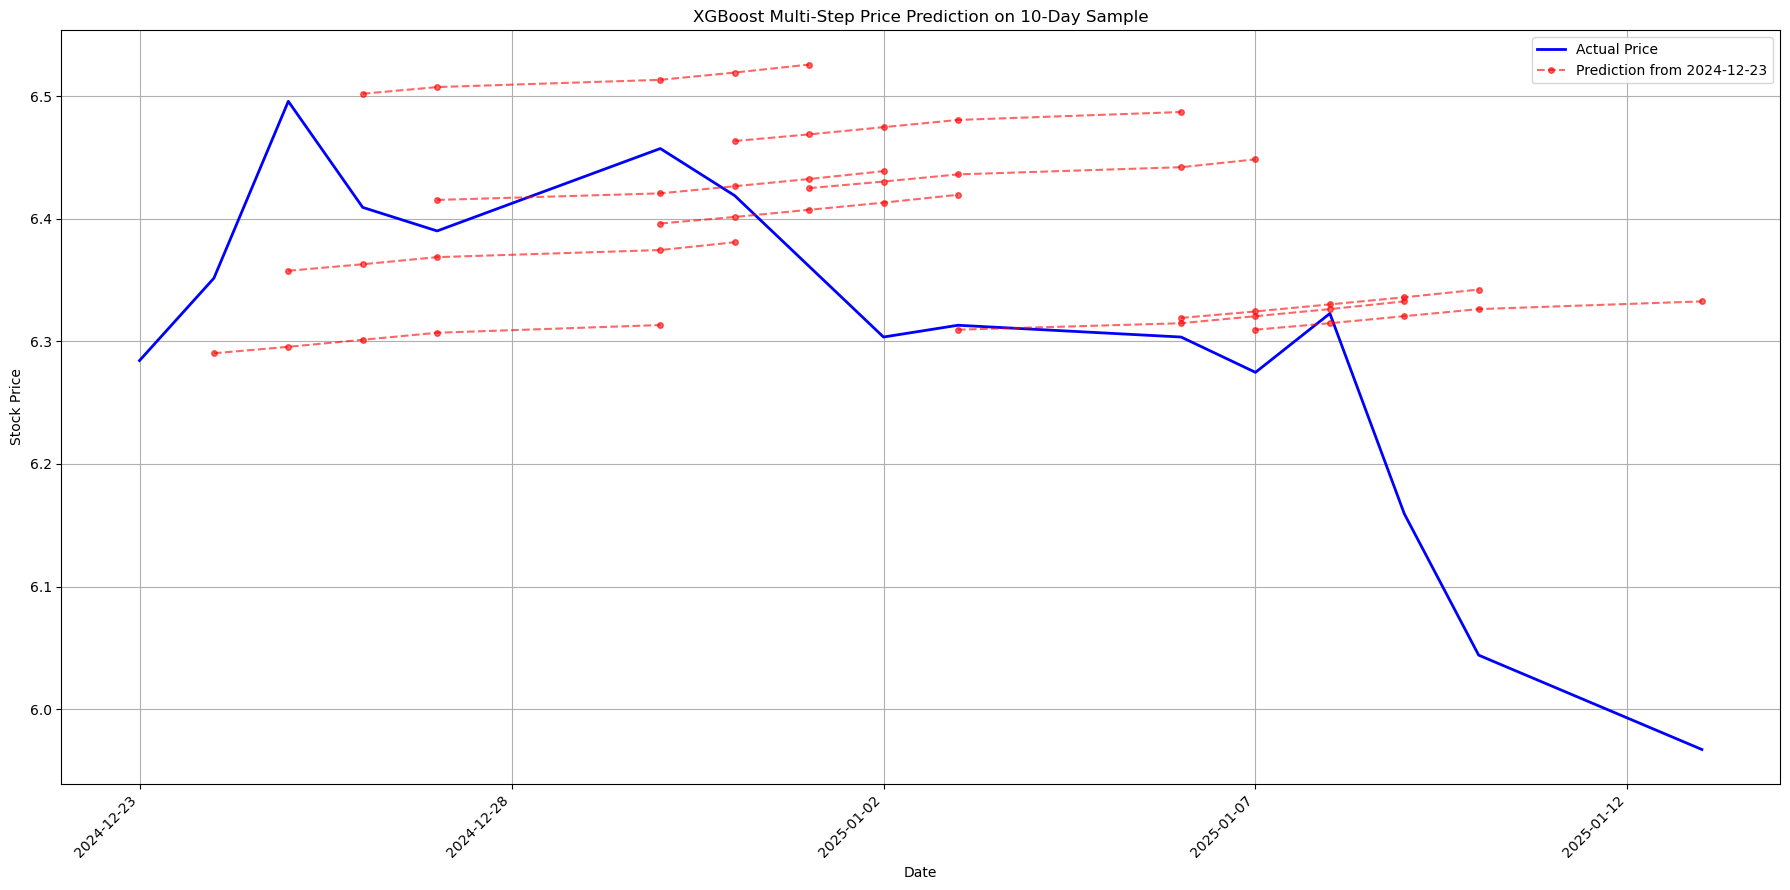

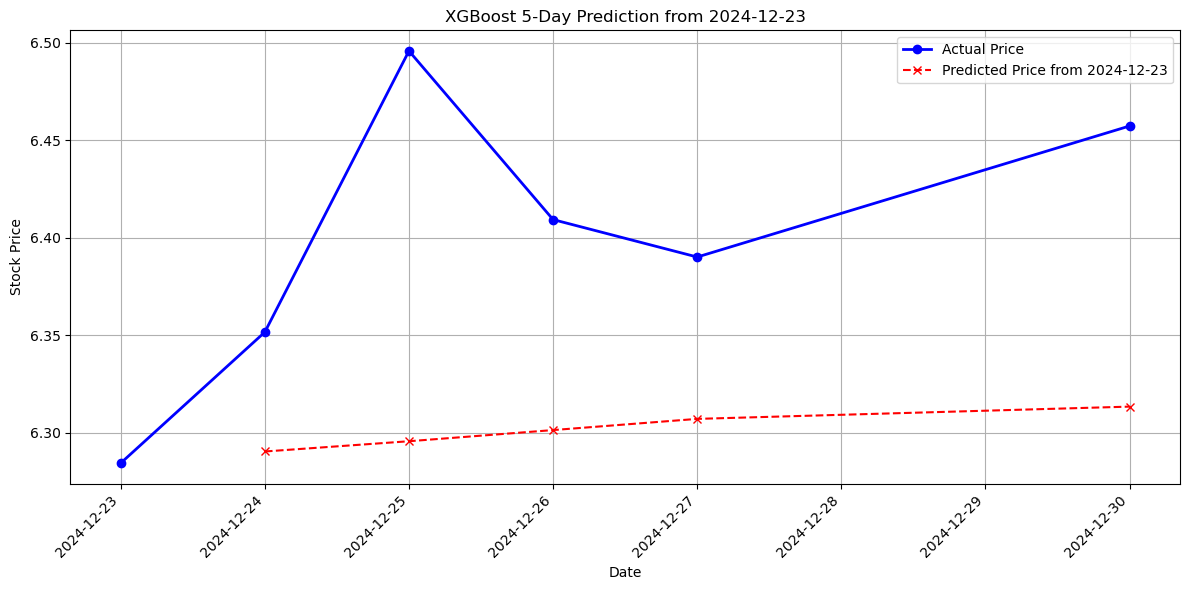

In [14]:
print("--- 1. 选择小样本数据 ---")

# 确保 train_val_df 可用，用于填充缺失值
train_val_df = pd.concat([train_df, val_df])

# 从 test_df 中选择一个 10 天的连续样本
# 可以调整 start_index 来选择不同的 10 天
start_index = 50 # 例如，从 test_df 的第 50 个交易日开始
sample_size = 10
sample_df = test_df.iloc[start_index : start_index + sample_size + 5].copy() # +5 额外天数用于显示真实未来价格

# 确保 sample_df 的索引是 datetime 类型，以便在绘图中显示日期
# 假设 test_df.index 已经是日期，或者我们需要将其转换
# 如果不是，请取消注释并根据您的实际日期列进行调整
# sample_df.index = pd.to_datetime(sample_df['date_column'])

# 我们需要知道原始 test_df 的起始索引，以便正确地绘制 x 轴
test_df_start_idx = len(train_df) + len(val_df) + start_index

print(f"已选择从测试集索引 {start_index} 开始的 {sample_size} 天样本进行可视化预测。")

print("--- 2. 在小样本上进行未来5天的滚动预测 ---")

# 用于存储所有预测路径的 DataFrame
# 索引为预测起点的时间戳，列为 'pred_price_t+1', 'pred_price_t+2', ...
all_predictions = pd.DataFrame(index=sample_df.index[:sample_size])

# 循环遍历小样本的每一天 (作为预测的起点)
for i in range(sample_size):
    current_day_data = sample_df.iloc[[i]] # 获取当前T时刻的特征
    current_close_price = current_day_data['close'].iloc[0] # 获取当前T时刻的收盘价
    
    # 获取当前预测起点的时间戳，用于将预测路径存储到正确的索引
    current_prediction_start_idx = sample_df.index[i]

    # 对当前这一天，预测未来 T+1 到 T+5
    for j, target in enumerate(targets, 1):
        model = models[target]
        features_list_for_target = features[target]
        
        # 填充缺失值 (使用训练/验证集的均值)
        fill_means = train_val_df[features_list_for_target].mean()
        X_current_day_filled = current_day_data[features_list_for_target].fillna(fill_means)
        
        # 预测 pct_chg
        pred_pct_chg = model.predict(X_current_day_filled)[0] # [0] 因为是单行预测
        
        # 转换为预测价格
        pred_price = current_close_price * (pred_pct_chg + 1)
        
        # 将预测价格存储到 all_predictions DataFrame
        all_predictions.loc[current_prediction_start_idx, f'pred_price_t+{j}'] = pred_price

print("小样本预测完成。")
print(all_predictions.head())

print("\n--- 3. 绘制预测图表 ---")

fig, ax = plt.subplots(figsize=(18, 9))

# 绘制小样本的真实价格曲线 (包括预测期后的几天，以便对比)
ax.plot(sample_df.index, sample_df['close'], label='Actual Price', color='blue', linewidth=2)

# 绘制每个预测起点的未来5天预测路径
for i in range(sample_size):
    start_time = sample_df.index[i]
    
    # X 轴上的实际日期点（从预测起点开始）
    x_plot_points = pd.date_range(start=start_time, periods=6, freq='B')[1:] # 忽略起始点，取未来5个工作日
    # 注意：freq='B' 是工作日频率，如果您的数据包含周末/节假日，需要调整或使用整数索引

    # 获取该预测起点对应的预测价格
    y_pred_prices = [all_predictions.loc[start_time, f'pred_price_t+{j}'] for j in range(1, 6)]
    
    # 绘制预测路径
    ax.plot(x_plot_points, y_pred_prices, color='red', linestyle='--', marker='o', markersize=4, alpha=0.6,
            label=f'Prediction from {start_time.strftime("%Y-%m-%d")}' if i == 0 else "_nolegend_") # 只给第一条线加标签

# 绘制真实的未来价格点（如果有的话）
# 理论上，sample_df 已经包含了这些，只是没有作为单独的预测线
# 如果需要，可以单独突出显示预测期结束后的真实价格
# ax.plot(sample_df.index[sample_size:], sample_df['close'].iloc[sample_size:], label='Actual Price After Forecast', color='green', linestyle=':', marker='x')


# 格式化 X 轴日期
ax.xaxis.set_major_locator(ticker.AutoLocator()) # 自动选择合适的刻度
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title(f'XGBoost Multi-Step Price Prediction on {sample_size}-Day Sample')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 为了更好地可视化，我们可以创建一个小图来显示某个特定日期的预测
target_date_idx = 0 # 选择小样本中的第一天进行展示
target_date = sample_df.index[target_date_idx]

plt.figure(figsize=(12, 6))
plt.plot(sample_df.index[:target_date_idx+6], sample_df['close'].iloc[:target_date_idx+6], label='Actual Price', color='blue', linewidth=2, marker='o')

# 绘制预测
x_plot_points_single = pd.date_range(start=target_date, periods=6, freq='B')[1:]
y_pred_prices_single = [all_predictions.loc[target_date, f'pred_price_t+{j}'] for j in range(1, 6)]
plt.plot(x_plot_points_single, y_pred_prices_single, color='red', linestyle='--', marker='x', markersize=6, label=f'Predicted Price from {target_date.strftime("%Y-%m-%d")}')

plt.title(f'XGBoost 5-Day Prediction from {target_date.strftime("%Y-%m-%d")}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()